In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from skforecast.ForecasterAutoreg import ForecasterAutoreg
# from skforecast.model_selection import grid_search_forecaster
# from skforecast.model_selection import time_series_spliter
# from skforecast.model_selection import cv_forecaster

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterCustom import ForecasterCustom

## ForecasterAutoregMultiOutput

In [4]:
################################################################################
#                               skforecast                                     #
#                                                                              #
# This work by Joaquín Amat Rodrigo is licensed under a Creative Commons       #
# Attribution 4.0 International License.                                       #
################################################################################
# coding=utf-8

import typing
from typing import Union, Dict
import warnings
import logging
import numpy as np
import pandas as pd
import sklearn
import tqdm

from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


logging.basicConfig(
    format = '%(asctime)-5s %(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.INFO,
)


################################################################################
#                         ForecasterAutoregMultiOutput                         #
################################################################################

class ForecasterAutoregMultiOutput():
    '''
    This class turns a scikit-learn regressor into a autoregressive multi-output
    forecaster. A separate model is created for each forecast time step. See Notes
    for more details.
    
    Parameters
    ----------
    regressor : scikit-learn regressor
        An instance of a scikit-learn regressor.
        
    lags : int, list, 1D np.array, range
        Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1.
            `int`: include lags from 1 to `lags` (included).
            `list` or `np.array`: include only lags present in `lags`.
            
    steps : int
        Number of future steps the forecaster will predict when using method
        `predict()`. Since a diferent model is created for each step, this value
        should be defined before training.
    
    Attributes
    ----------
    regressor : scikit-learn regressor
        An instance of a scikit-learn regressor.
        
    steps : int
        Number of future steps the forecaster will predict when using method
        `predict()`. Since a diferent model is created for each step, this value
        should be defined before training.
        
    lags : 1D np.array
        Lags used as predictors.
        
    max_lag : int
        Maximum value of lag included in lags.
        
    last_window : 1D np.ndarray
        Last time window the forecaster has seen when trained. It stores the
        values needed to calculate the lags used to predict the next `step`
        after the training data.
        
    included_exog : bool
        If the forecaster has been trained using exogenous variable/s.
        
    exog_type : type
        Type used for the exogenous variable/s.
            
    exog_shape : tuple
        Shape of exog used in training.
        
    in_sample_residuals: np.ndarray
        Residuals of the model when predicting training data.
        
    out_sample_residuals: np.ndarray
        Residuals of the model when predicting non training data.
        
        
    Notes
    -----
    A separate model is created for each forecast time step using
    `sklearn.multioutput.MultiOutputRegressor`. This scikit learn class
    is a wrapper that automize fitting one regressor per target. It is important
    to note that all models share the same configuration of parameters and 
    hiperparameters.
     
    '''
    
    def __init__(self, regressor, steps: int,
                 lags: Union[int, np.ndarray, list]) -> None:
        
        self.regressor     = MultiOutputRegressor(regressor)
        self.steps         = steps
        self.last_window   = None
        self.included_exog = False
        self.exog_type     = False
        self.exog_shape    = None
        self.in_sample_residuals  = None
        self.out_sample_residuals = None
        
        if not isinstance(steps, int) or steps < 1:
            raise Exception(
                f"`steps` must be integer greater than 0. Got {steps}."
            )
        
        if isinstance(lags, int) and lags < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise Exception(
                f"`lags` argument must be `int`, `1D np.ndarray`, `range` or `list`. "
                f"Got {type(lags)}"
            )
            
        self.max_lag  = max(self.lags)
                
        
    def __repr__(self) -> str:
        '''
        Information displayed when a ForecasterAutoreg object is printed.
        '''

        info =    "============================" \
                + "ForecasterAutoregMultiOutput" \
                + "============================" \
                + "\n" \
                + "Regressor: " + str(self.regressor) \
                + "\n" \
                + "Steps: " + str(self.steps) \
                + "\n" \
                + "Lags: " + str(self.lags) \
                + "\n" \
                + "Exogenous variable: " + str(self.included_exog) \
                + "\n" \
                + "Parameters: " + str(self.regressor.get_params())

        return info

    
    def create_lags(self, y: Union[np.ndarray, pd.Series]) -> Dict[np.ndarray, np.ndarray]:
        '''
        Transforms a time series into two 2D arrays of pairs predictor-response.
        
        Notice that the returned matrix X_data, contains the lag 1 in the
        first column, the lag 2 in the second column and so on.
        
        Parameters
        ----------        
        y : 1D np.ndarray, pd.Series
            Training time series.

        Returns 
        -------
        X_data : 2D np.ndarray
            2D array with the lag values (predictors).
        
        y_data : 2D np.ndarray
            Values of the time series related to each row of `X_data`.
            
        '''
        
        self._check_y(y=y)
        y = self._preproces_y(y=y)        
        
        if self.max_lag > len(y):
            raise Exception(
                f"Maximum lag can't be higer than `y` length. "
                f"Got maximum lag={self.max_lag} and `y` length={len(y)}."
            )
            
        n_splits = len(y) - self.max_lag - (self.steps -1)
        X_data  = np.full(shape=(n_splits, self.max_lag), fill_value=np.nan, dtype=float)
        y_data  = np.full(shape=(n_splits, self.steps), fill_value=np.nan, dtype= float)

        for i in range(n_splits):
            train_index = np.arange(i, self.max_lag + i)
            test_index  = np.arange(self.max_lag + i, self.max_lag + i + self.steps)

            X_data[i, :] = y[train_index]
            y_data[i, :] = y[test_index]
            
        X_data = X_data[:, -self.lags]
                    
        return X_data, y_data

        
    def fit(self, y: Union[np.ndarray, pd.Series],
            exog: Union[np.ndarray, pd.Series]=None) -> None:
        '''
        Training ForecasterAutoregMultiOutput
        
        Parameters
        ----------        
        y : 1D np.ndarray, pd.Series
            Training time series.
            
        exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].


        Returns 
        -------
        self : ForecasterAutoregMultiOutput
            Trained ForecasterAutoregMultiOutput
        
        '''
        
        # Reset values in case the forecaster has already been fitted before.
        self.included_exog = False
        self.exog_type     = None
        self.exog_shape    = None
        
        self._check_y(y=y)
        y = self._preproces_y(y=y)
        
        if exog is not None:
            self._check_exog(exog=exog)
            self.exog_type = type(exog)
            exog = self._preproces_exog(exog=exog)
            self.included_exog = True
            self.exog_shape = exog.shape
            
            if exog.shape[0] != len(y):
                raise Exception(
                    f"`exog` must have same number of samples as `y`"
                )
                
            # Trasform exog to match multi output format
            exog = self._exog_to_multi_output(exog=exog)               
        
        X_train, y_train = self.create_lags(y=y)
        
        if exog is not None:
            self.regressor.fit(
                # The first `self.max_lag` positions have to be removed from exog
                # since they are not in X_train.
                X = np.column_stack((X_train, exog[self.max_lag:,])),
                y = y_train
            )
            self.in_sample_residuals = \
                y_train - self.regressor.predict(
                                np.column_stack((X_train, exog[self.max_lag:,]))
                          )
        else:
            self.regressor.fit(X=X_train, y=y_train)
            self.in_sample_residuals = y_train - self.regressor.predict(X_train)
        
        # The last time window of training data is stored so that lags needed as
        # predictors in the first iteration of `predict()` can be calculated.
        self.last_window = y_train[-1][-self.max_lag:]
        
        
            
    def predict(self, last_window: Union[np.ndarray, pd.Series]=None,
                exog: np.ndarray=None, steps=None):
        '''
        Multi-step prediction with a MultiOutputRegressor. The number of future
        steps predicted is defined when ininitializing the forecaster.
        
        Parameters
        ----------
            
        last_window : 1D np.ndarray, pd.Series, shape (, max_lag), default `None`
            Values of the series used to create the predictors (lags) need in the 
            first iteration of predictiont (t + 1).
    
            If `last_window = None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s.
            
        steps : Ignored
            Not used, present here for API consistency by convention.

        Returns 
        -------
        predictions : 1D np.array, shape (steps,)
            Values predicted.
            
        '''
        
        if exog is None and self.included_exog:
            raise Exception(
                f"Forecaster trained with exogenous variable/s. "
                f"Same variable/s must be provided in `predict()`."
            )
            
        if exog is not None and not self.included_exog:
            raise Exception(
                f"Forecaster trained without exogenous variable/s. "
                f"`exog` must be `None` in `predict()`."
            )
        
        if exog is not None:
            self._check_exog(
                exog=exog, ref_type = self.exog_type, ref_shape=self.exog_shape
            )
            exog = self._preproces_exog(exog=exog)
            if exog.shape[0] < self.steps:
                raise Exception(
                    f"`exog` must have at least as many values as `steps` predicted."
                )
            exog = self._exog_to_multi_output(exog=exog)
     
        if last_window is not None:
            self._check_last_window(last_window=last_window)
            last_window = self._preproces_last_window(last_window=last_window)
            if last_window.shape[0] < self.max_lag:
                raise Exception(
                    f"`last_window` must have as many values as as needed to "
                    f"calculate the maximum lag ({self.max_lag})."
                )
        else:
            last_window = self.last_window.copy()
            
        X = last_window[-self.lags].reshape(1, -1)
        if exog is None:
            predictions = self.regressor.predict(X=X)
        else:
            X = np.hstack([X, exog[0].reshape(1, -1)])
            predictions = self.regressor.predict(
                            X = X
                          )
            
        predictions = predictions.reshape(-1)
            
        return predictions
    
    
    def _check_y(self, y: Union[np.ndarray, pd.Series]) -> None:
        '''
        Raise Exception if `y` is not 1D `np.ndarray` or `pd.Series`.
        
        Parameters
        ----------        
        y : np.ndarray, pd.Series
            Time series values

        '''
        
        if not isinstance(y, (np.ndarray, pd.Series)):
            raise Exception('`y` must be `1D np.ndarray` or `pd.Series`.')
        elif isinstance(y, np.ndarray) and y.ndim != 1:
            raise Exception(
                f"`y` must be `1D np.ndarray` o `pd.Series`, "
                f"got `np.ndarray` with {y.ndim} dimensions."
            )
            
        return
    
    
    def _check_last_window(self, last_window: Union[np.ndarray, pd.Series]) -> None:
        '''
        Raise Exception if `last_window` is not 1D `np.ndarray` or `pd.Series`.
        
        Parameters
        ----------        
        last_window : np.ndarray, pd.Series
            Time series values

        '''
        
        if not isinstance(last_window, (np.ndarray, pd.Series)):
            raise Exception('`last_window` must be `1D np.ndarray` or `pd.Series`.')
        elif isinstance(last_window, np.ndarray) and last_window.ndim != 1:
            raise Exception(
                f"`last_window` must be `1D np.ndarray` o `pd.Series`, "
                f"got `np.ndarray` with {last_window.ndim} dimensions."
            )
            
        return
        
        
    def _check_exog(self, exog: Union[np.ndarray, pd.Series], 
                    ref_type: type=None, ref_shape: tuple=None) -> None:
        '''
        Raise Exception if `exog` is not `np.ndarray` or `pd.Series`.
        If `ref_shape` is provided, raise Exception if `ref_shape[1]` do not match
        `exog.shape[1]` (number of columns).
        
        Parameters
        ----------        
        exog : np.ndarray, pd.Series
            Time series values

        '''
            
        if not isinstance(exog, (np.ndarray, pd.Series)):
            raise Exception('`exog` must be `np.ndarray` or `pd.Series`.')
            
        if isinstance(exog, np.ndarray) and exog.ndim > 2:
            raise Exception(
                    f" If `exog` is `np.ndarray`, maximum allowed dim=2. "
                    f"Got {exog.ndim}."
                )
            
        if ref_type is not None:
            
            if ref_type == pd.Series:
                if isinstance(exog, pd.Series):
                    return
                elif isinstance(exog, np.ndarray) and exog.ndim == 1:
                    return
                elif isinstance(exog, np.ndarray) and exog.shape[1] == 1:
                    return
                else:
                    raise Exception(
                        f"`exog` must be: `pd.Series`, `np.ndarray` with 1 dimension"
                        f"or `np.ndarray` with 1 column in the second dimension. "
                        f"Got `np.ndarray` with {exog.shape[1]} columns."
                    )
                    
            if ref_type == np.ndarray:
                if exog.ndim == 1 and ref_shape[1] == 1:
                    return
                elif exog.ndim == 1 and ref_shape[1] > 1:
                    raise Exception(
                        f"`exog` must have {ref_shape[1]} columns. "
                        f"Got `np.ndarray` with 1 dimension or `pd.Series`."
                    )
                elif ref_shape[1] != exog.shape[1]:
                    raise Exception(
                        f"`exog` must have {ref_shape[1]} columns. "
                        f"Got `np.ndarray` with {exog.shape[1]} columns."
                    )     
        return
    
        
    def _preproces_y(self, y) -> np.ndarray:
        
        '''
        Transforms `y` to 1D `np.ndarray` if it is `pd.Series`.
        
        Parameters
        ----------        
        y :1D np.ndarray, pd.Series
            Time series values

        Returns 
        -------
        y: 1D np.ndarray, shape(samples,)
        '''
        
        if isinstance(y, pd.Series):
            return y.to_numpy().copy()
        else:
            return y.copy()
        
    def _preproces_last_window(self, last_window) -> np.ndarray:
        
        '''
        Transforms `last_window` to 1D `np.ndarray` if it is `pd.Series`.
        
        Parameters
        ----------        
        last_window :1D np.ndarray, pd.Series
            Time series values

        Returns 
        -------
        last_window: 1D np.ndarray, shape(samples,)
        '''
        
        if isinstance(last_window, pd.Series):
            return last_window.to_numpy().copy()
        else:
            return last_window.copy()
        
        
    def _preproces_exog(self, exog) -> np.ndarray:
        
        '''
        Transforms `exog` to `np.ndarray` if it is `pd.Series`.
        If 1D `np.ndarray` reshape it to (n_samples, 1)
        
        Parameters
        ----------        
        exog : np.ndarray, pd.Series
            Time series values

        Returns 
        -------
        exog: np.ndarray, shape(samples,)
        '''
        
        if isinstance(exog, pd.Series):
            exog_prep = exog.to_numpy().reshape(-1, 1).copy()
        elif isinstance(exog, np.ndarray) and exog.ndim == 1:
            exog_prep = exog.reshape(-1, 1).copy()
        else:
            exog_prep = exog.copy()
            
        return exog_prep
    
    def _exog_to_multi_output(self, exog):
        
        '''
        Transforms `exog` to `np.ndarray` with the shape needed for multioutput
        regresors.
        
        Parameters
        ----------        
        exog : np.ndarray, shape(samples,)
            Time series values

        Returns 
        -------
        exog_transformed: np.ndarray, shape(samples - self.max_lag, self.steps)
        '''

        exog_transformed = []

        for column in range(exog.shape[1]):

            exog_column_transformed = []

            for i in range(exog.shape[0] - (self.steps -1)):
                exog_column_transformed.append(exog[i:i + self.steps, column])

            if len(exog_column_transformed) > 1:
                exog_column_transformed = np.vstack(exog_column_transformed)

            exog_transformed.append(exog_column_transformed)

        if len(exog_transformed) > 1:
            exog_transformed = np.hstack(exog_transformed)
        else:
            exog_transformed = exog_column_transformed

        return exog_transformed
    
    
    def set_params(self, **params: dict) -> None:
        '''
        Set new values to the parameters of the scikit learn model stored in the
        forecaster. A separate model is created for each forecast time step using
        `sklearn.multioutput.MultiOutputRegressor`. This scikit learn class is a
        wrapper that automize fitting one regressor per target. It is important
        to note that all models share the same configuration of parameters and 
        hiperparameters.
        
        Parameters
        ----------
        params : dict
            Parameters values.

        Returns 
        -------
        self
        
        '''
        
        self.regressor.set_params(**params)
        
        
    def set_lags(self, lags: int) -> None:
        '''      
        Set new value to the attribute `lags`.
        Attribute `max_lag` is also updated.
        
        Parameters
        ----------
        lags : int, list, 1D np.array, range
        Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1.
            `int`: include lags from 1 to `lags`.
            `list` or `np.array`: include only lags present in `lags`.

        Returns 
        -------
        self
        
        '''
        
        if isinstance(lags, int) and lags < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise Exception(
                f"`lags` argument must be `int`, `1D np.ndarray`, `range` or `list`. "
                f"Got {type(lags)}"
            )
            
        self.max_lag  = max(self.lags)
        

    def get_coef(self, step) -> np.ndarray:
        '''      
        Return estimated coefficients for the linear regression model stored in
        the forecaster for a specific step. Since a separate model is created for
        each forecast time step, it is necessary to select the model from which
        retireve information.
        
        Only valid when the forecaster has been trained using as `regressor:
        `LinearRegression()`, `Lasso()` or `Ridge()`.
        
        Parameters
        ----------
        step : int
            Model from which retireve information (a separate model is created for
            each forecast time step).

        Returns 
        -------
        coef : 1D np.ndarray
            Value of the coefficients associated with each predictor (lag).
            Coefficients are aligned so that `coef[i]` is the value associated
            with `self.lags[i]`.
        
        '''
        
        if step > self.steps:
            raise Exception(
                f"Forecaster traied for {self.steps} steps. Got step={step}."
            )
            
        
        valid_instances = (sklearn.linear_model._base.LinearRegression,
                           sklearn.linear_model._coordinate_descent.Lasso,
                           sklearn.linear_model._ridge.Ridge
                           )
        
        if not isinstance(self.regressor.estimator, valid_instances):
            warnings.warn(
                ('Only forecasters with `regressor` `LinearRegression()`, ' +
                 ' `Lasso()` or `Ridge()` have coef.')
            )
            return
        else:
            coef = self.regressor.estimators_[step-1].coef_
            
        return coef

    
    def get_feature_importances(self, step) -> np.ndarray:
        '''      
        Return impurity-based feature importances of the model stored in
        the forecaster for a specific step. Since a separate model is created for
        each forecast time step, it is necessary to select the model from which
        retireve information.
        
        Only valid when the forecaster has been trained using
        `regressor=GradientBoostingRegressor()` or `regressor=RandomForestRegressor`.

        Parameters
        ----------
        step : int
            Model from which retireve information (a separate model is created for
            each forecast time step).

        Returns 
        -------
        feature_importances : 1D np.ndarray
        Impurity-based feature importances associated with each predictor (lag).
        Values are aligned so that `feature_importances[i]` is the value
        associated with `self.lags[i]`.
        '''
        
        if step > self.steps:
            raise Exception(
                f"Forecaster traied for {self.steps} steps. Got step={step}."
            )
        
        valid_instances = (sklearn.ensemble._forest.RandomForestRegressor,
                           sklearn.ensemble._gb.GradientBoostingRegressor)

        if not isinstance(self.regressor.estimator, valid_instances):
            warnings.warn(
                ('Only forecasters with `regressor=GradientBoostingRegressor()` '
                 'or `regressor=RandomForestRegressor`.')
            )
            return
        else:
            feature_importances = self.regressor.estimators_[step-1].feature_importances_

        return feature_importances

In [5]:
################################################################################
#                        skforecast.model_selection                            #
#                                                                              #
# This work by Joaquín Amat Rodrigo is licensed under a Creative Commons       #
# Attribution 4.0 International License.                                       #
################################################################################
# coding=utf-8


import typing
from typing import Union, Dict
import numpy as np
import pandas as pd
import logging
import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

# from .ForecasterAutoreg import ForecasterAutoreg
# from .ForecasterCustom import ForecasterCustom

logging.basicConfig(
    format = '%(asctime)-5s %(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.INFO,
)


def time_series_spliter(y: Union[np.ndarray, pd.Series],
                        initial_train_size: int, steps: int,
                        allow_incomplete_fold: bool=True,
                        verbose: bool=True):
    '''
    
    Split indices of a time series into multiple train-test pairs. The order of
    is maintained and the training set increases in each iteration.
    
    Parameters
    ----------        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    allow_incomplete_fold : bool, default `True`
        The last test set is allowed to be incomplete if it does not reach `steps`
        observations. Otherwise, the latest observations are discarded.
        
    verbose : bool, default `True`
        Print number of splits created.

    Yields
    ------
    train : 1D np.ndarray
        Training indices.
        
    test : 1D np.ndarray
        Test indices.
        
    '''
    
    if not isinstance(y, (np.ndarray, pd.Series)):

        raise Exception('`y` must be `1D np.ndarray` o `pd.Series`.')

    elif isinstance(y, np.ndarray) and y.ndim != 1:

        raise Exception(
            f"`y` must be `1D np.ndarray` o `pd.Series`, "
            f"got `np.ndarray` with {y.ndim} dimensions."
        )
        
    if isinstance(y, pd.Series):
        y = y.to_numpy().copy()
    
  
    folds     = (len(y) - initial_train_size) // steps  + 1
    remainder = (len(y) - initial_train_size) % steps   
    
    if verbose:
        print(f"Number of folds: {folds}")
        if remainder != 0 and allow_incomplete_fold:
            print(
                f"Since `allow_incomplete_fold=True`, "
                f"last fold includes {remainder} extra observations."
            )
        elif remainder != 0 and not allow_incomplete_fold:
            print(
                f"Since `allow_incomplete_fold=False`, "
                f"last {remainder} observations are descarted."
            )
        
    
    for i in range(folds):
          
        if i < folds - 1:
            train_end     = initial_train_size + i * steps    
            train_indices = range(train_end)
            test_indices  = range(train_end, train_end + steps)
            
        else:
            if remainder != 0 and allow_incomplete_fold:
                train_end     = initial_train_size + i * steps  
                train_indices = range(train_end)
                test_indices  = range(train_end, train_end + remainder)
            else:
                break
        
        yield train_indices, test_indices
        

def cv_forecaster(forecaster, y: Union[np.ndarray, pd.Series],
                  initial_train_size: int, steps: int,
                  metric: str, exog: Union[np.ndarray, pd.Series]=None,
                  allow_incomplete_fold: bool=True, verbose: bool=True):
    '''
    Cross-validation of `ForecasterAutoreg` or `ForecasterCustom` object.
    The order of is maintained and the training set increases in each iteration.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg, ForecasterCustom
        `ForecasterAutoreg` or `ForecasterCustom` object.
        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    metric : {'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'}
        Metric used to quantify the goodness of fit of the model.
        
    exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].
            
    allow_incomplete_fold : bool, default `True`
        The last test set is allowed to be incomplete if it does not reach `steps`
        observations. Otherwise, the latest observations are discarded.
        
    verbose : bool, default `True`
        Print number of folds used for cross validation.

    Returns 
    -------
    cv_results: 1D np.ndarray
        Value of the metric for each partition.

    '''
    
    forecaster._check_y(y=y)
    y = forecaster._preproces_y(y=y)
    
    if exog is not None:
        forecaster._check_exog(exog=exog)
        exog = forecaster._preproces_exog(exog=exog)
    
    cv_results = []
    
    metrics = {
        'neg_mean_squared_error': mean_squared_error,
        'neg_mean_absolute_error': mean_absolute_error,
        'neg_mean_absolute_percentage_error': mean_absolute_percentage_error
    }
    
    metric = metrics[metric]
    
    splits = time_series_spliter(
                y                     = y,
                initial_train_size    = initial_train_size,
                steps                 = steps,
                allow_incomplete_fold = allow_incomplete_fold,
                verbose               = verbose
             )
    
    for train_index, test_index in splits:
        
        if exog is None:
            forecaster.fit(y=y[train_index])      
            pred = forecaster.predict(steps=len(test_index))
            
        else:
            
            forecaster.fit(y=y[train_index], exog=exog[train_index])      
            pred = forecaster.predict(steps=len(test_index), exog=exog[test_index])
               
        metric_value = metric(
                            y_true = y[test_index],
                            y_pred = pred
                       )
        
        cv_results.append(metric_value)
                          
    return np.array(cv_results)


def backtesting_forecaster(forecaster, y: Union[np.ndarray, pd.Series],
                           initial_train_size: int, steps: int,
                           metric: str, exog: Union[np.ndarray, pd.Series]=None,
                           verbose: bool=True):
    '''
    Backtesting (validation) of `ForecasterAutoreg` or `ForecasterCustom` object.
    The model is trained only once using the `initial_train_size` first observations.
    In each iteration, a number of `steps` predictions are evaluated.
    
    This evaluation is much faster than `cv_forecaster()` since the model is
    trained only once.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg, ForecasterCustom
        `ForecasterAutoreg` or `ForecasterCustom` object.
        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    metric : {'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'}
        Metric used to quantify the goodness of fit of the model.
        
    exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].
            
    verbose : bool, default `True`
        Print number of folds used for backtesting.

    Returns 
    -------
    backtest_predictions: 1D np.ndarray
        Value of predictions.
        
    metric_value: np.ndarray shape (1,)
        Value of the metric.

    '''
    
    forecaster._check_y(y=y)
    y = forecaster._preproces_y(y=y)
    
    if exog is not None:
        forecaster._check_exog(exog=exog)
        exog = forecaster._preproces_exog(exog=exog)
    
    backtest_predictions = []
    
    metrics = {
        'neg_mean_squared_error': mean_squared_error,
        'neg_mean_absolute_error': mean_absolute_error,
        'neg_mean_absolute_percentage_error': mean_absolute_percentage_error
    }
    
    metric = metrics[metric]
        
    if exog is None:
        forecaster.fit(y=y[:initial_train_size])      
    else:
        forecaster.fit(y=y[:initial_train_size], exog=exog[:initial_train_size])     
    
    
    folds     = (len(y) - initial_train_size) // steps + 1
    remainder = (len(y) - initial_train_size) % steps
    window_size = len(forecaster.last_window)
    
    if isinstance(forecaster, ForecasterAutoregMultiOutput) and remainder != 0:
        # In ForecasterAutoregMultiOutput predictions are not iterative,
        # therefore no remainder is allowed.
        remainder=0
        logging.warning(
                f"Backtesting `ForecasterAutoregMultiOutput` only allow completed "
                f"folds. Last {remainder} observations are excluded."
            )
    
    if verbose:
        print(f"Number of observations used for training: {initial_train_size}")
        print(f"Number of folds: {folds}")
        if remainder != 0:
            print(f"Last fold only includes {remainder} observations.")
    
    for i in range(folds):
        last_window_end   = initial_train_size + i * steps
        last_window_start = (initial_train_size + i * steps) - window_size 
        last_window       = y[last_window_start:last_window_end]
                
        if i < folds - 1:
            if exog is None:
                pred = forecaster.predict(
                            steps       = steps,
                            last_window = last_window
                        )
            else:
                pred = forecaster.predict(
                            steps       = steps,
                            last_window = last_window,
                            exog        = exog[last_window_end:last_window_end + steps]
                        )
        elif remainder != 0:
            steps = remainder 
            if exog is None:
                pred = forecaster.predict(
                            steps       = steps,
                            last_window = last_window
                        )
            else:
                pred = forecaster.predict(
                            steps       = steps,
                            last_window = last_window,
                            exog        = exog[last_window_end:last_window_end + steps]
                        )
        else:
            continue
        
        backtest_predictions.append(pred)
    
    backtest_predictions = np.concatenate(backtest_predictions)
    metric_value = metric(
                        y_true = y[initial_train_size: initial_train_size + len(backtest_predictions)],
                        y_pred = backtest_predictions
                   )

    return np.array([metric_value]), backtest_predictions



def grid_search_forecaster(forecaster, y: Union[np.ndarray, pd.Series],
                           param_grid: dict, initial_train_size: int, steps: int,
                           metric: str, exog: Union[np.ndarray, pd.Series]=None,
                           lags_grid: list=None, method: str='cv',
                           allow_incomplete_fold: bool=True, return_best: bool=True,
                           verbose: bool=True):
    '''
    Exhaustive search over specified parameter values for a Forecaster object.
    Validation is done using time series cross-validation or backtesting.
    
    Parameters
    ----------
    
    forecaster : ForecasterAutoreg, ForecasterCustom
        ForecasterAutoreg or ForecasterCustom object.
        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
        
    param_grid : dict
        Dictionary with parameters names (`str`) as keys and lists of parameter
        settings to try as values.
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    metric : {'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'}
        Metric used to quantify the goodness of fit of the model.
        
    exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].
           
    lags_grid : list of int, lists, np.narray or range. 
        Lists of `lags` to try. Only used if forecaster is an instance of 
        `ForecasterCustom`.
        
    method : {'cv', 'backtesting'}
        Method used to estimate the metric for each parameter combination.
        'cv' for time series crosvalidation and 'backtesting' for simple
        backtesting. 'backtesting' is much faster since the model is fitted only
        once.
        
    allow_incomplete_fold : bool, default `True`
        The last test set is allowed to be incomplete if it does not reach `steps`
        observations. Otherwise, the latest observations are discarded.
        
    return_best : bool
        Refit the `forecaster` using the best found parameters on the whole data.
        
    verbose : bool, default `True`
        Print number of folds used for cv or backtesting.

    Returns 
    -------
    results: pandas.DataFrame
        Metric value estimated for each combination of parameters.

    '''
    
    forecaster._check_y(y=y)
    y = forecaster._preproces_y(y=y)
    
    if exog is not None:
        forecaster._check_exog(exog=exog)
        exog = forecaster._preproces_exog(exog=exog)
    
    if isinstance(forecaster, ForecasterCustom):
        if lags_grid is not None:
            logging.warning(
                '`lags_grid` ignored if forecaster is an instance of `ForecasterCustom`.'
            )
        lags_grid = ['custom predictors']
        
    elif lags_grid is None:
        lags_grid = [forecaster.lags]
        
    if isinstance(forecaster, ForecasterAutoregMultiOutput):
        param_grid_renamed = {'estimator__'+key: value for key, value in param_grid.items()}
        param_grid = param_grid_renamed
        
    lags_list = []
    params_list = []
    metric_list = []
    
    param_grid =  list(ParameterGrid(param_grid))
    
    for lags in tqdm.tqdm(lags_grid, desc='loop lags_grid', position=0):
        
        if isinstance(forecaster, ForecasterAutoreg):
            forecaster.set_lags(lags)
            lags = forecaster.lags.copy()
        
        for params in tqdm.tqdm(param_grid, desc='loop param_grid', position=1, leave=False):

            forecaster.set_params(**params)
            
            if method == 'cv':
                metrics = cv_forecaster(
                                forecaster = forecaster,
                                y          = y,
                                exog       = exog,
                                initial_train_size = initial_train_size,
                                steps  = steps,
                                metric = metric,
                                allow_incomplete_fold = allow_incomplete_fold,
                                verbose = verbose
                             )
            else:
                metrics = backtesting_forecaster(
                                forecaster = forecaster,
                                y          = y,
                                exog       = exog,
                                initial_train_size = initial_train_size,
                                steps  = steps,
                                metric = metric,
                                verbose = verbose
                             )[0]

            lags_list.append(lags)
            params_list.append(params)
            metric_list.append(metrics.mean())
            
    results = pd.DataFrame({
                'lags'  : lags_list,
                'params': params_list,
                'metric': metric_list})
    
    results = results.sort_values(by='metric', ascending=True)
    
    if return_best:
        
        best_lags = results['lags'].iloc[0]
        best_params = results['params'].iloc[0]
        logging.info(
            f"Refitting `forecaster` using the best found parameters: \n"
            f"lags: {best_lags} \n"
            f"params: {best_params}\n"
        )
        
        if isinstance(forecaster, ForecasterAutoreg):
            forecaster.set_lags(best_lags)
            
        forecaster.set_params(**best_params)
        forecaster.fit(y=y, exog=exog)
            
    return results

## Autoregressive multi-step forecaster

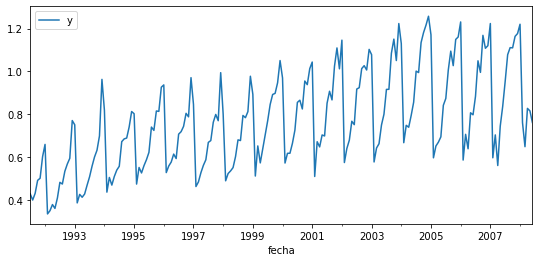

In [6]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [7]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 15
                )

a = forecaster.fit(y=datos_train)

Test error (mse): 0.009127719994536957


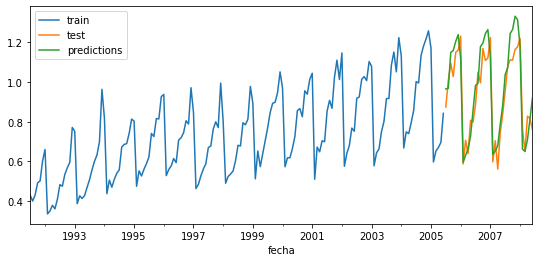

In [8]:
# Predict
# ==============================================================================
predictions = forecaster.predict()
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [9]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 3
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'neg_mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

loop lags_grid:  33%|███▎      | 1/3 [00:29<00:59, 29.71s/it] 


KeyboardInterrupt: 

In [ ]:
# Backtest 
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 15
             )

metrica, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = forecaster.steps,
                            metric     = 'neg_mean_squared_error',
                            verbose    = True
                       )

print(metrica)

# Se añade el índice temporal a las predicciones
predicciones_backtest = pd.Series(data=predictions, index=datos_test[:len(predictions)].index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Feature importance
# ==============================================================================
for step in range(1, forecaster.steps):
    print(f"\n Model step: {step}")
    print(forecaster.get_feature_importances(step = step))

## Autoreg + 1 exogenous predictor
<br>

In [ ]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
datos_exog = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog = datos_exog[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

In [ ]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 8
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)
forecaster

In [ ]:
# Predict
# ==============================================================================
predictions = forecaster.predict(
                    exog     = datos_exog_test
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Predict
# ==============================================================================
predictions = forecaster.predict(exog = datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Backtest 
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 8
                )

metrica, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = forecaster.steps,
                            metric     = 'neg_mean_squared_error'
                       )

print(metrica)

# Se añade el índice temporal a las predicciones
predicciones_backtest = pd.Series(data=predictions, index=datos_test[:len(predictions)].index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

## Autoregressive + n exogenous predictors
<br>

In [ ]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=10, closed='right').mean() + 1
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog_1.plot(ax=ax, label='exogenous variable 1')
datos_exog_2.plot(ax=ax, label='exogenous variable 2')
ax.legend();

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

In [ ]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)
forecaster

In [ ]:
# Predict
# ==============================================================================
predictions = forecaster.predict(
                    steps    = steps,
                    exog     = datos_exog_test
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Predict
# ==============================================================================
predictions = forecaster.predict(exog = datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Backtest 
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(),
                    steps     = 36,
                    lags      = 10
                )

metrica, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = forecaster.steps,
                            metric     = 'neg_mean_squared_error'
                       )

print(metrica)

# Se añade el índice temporal a las predicciones
predicciones_backtest = pd.Series(data=predictions, index=datos_test[:len(predictions)].index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

## Información de sesión

In [ ]:
from sinfo import sinfo
sinfo()